<a href="https://colab.research.google.com/github/owl-d/Basic_DeepLearning/blob/main/Doit_Ch06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***06 : 2개의 층을 연결합니다 - 다층 신경망***

***06-1 신경망 알고리즘의 벡터화해 한 번에 전체 샘플 사용***

In [1]:
#위스콘신 유방암 데이터

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [2]:
class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x): #정방향 계산
    z = np.dot(x, self.w) + self.b
    return z

  def backprop(self, x, err): #역방향 계산
    m = len(x)                    #샘플의 개수
    w_grad = np.dot(x.T, err) / m #가중치에 대한 평균 그레디언트
    b_grad = np.sum(err) / m      #절편에 대한 평균 그레디언트
    return w_grad, b_grad

  def activation(self, z):  #활성화 함수 메서드
    z = np.clip(z, -100, None)
    a = 1 / (1 + np.exp(-z))  #시그모이드 계산
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):  #forpass(), backprop() 메서드에서 전체 샘플 한 번에 계산하므로 각 샘플에 대한 두 번쨰 for문 사라짐
    y = y.reshape(-1, 1)  #target을 열 벡터로 바꾼다.
    y_val = y_val.reshape(-1, 1)
    m = len(x)            #샘플 개수
    self.w = np.ones((x.shape[1], 1))  #가중치 초기화
    self.b = 0                    #절편 초기화
    self.w_history.append(self.w.copy()) #가중치 기록
    for i in range(epochs):
      z = self.forpass(x)   #정방향 계산
      a = self.activation(z)   #활성화 함수 적용
      err = -(y - a)        #오차 계산
      w_grad, b_grad = self.backprop(x, err)  #역방향 계산
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m #L1규제와 L2규제 하나의 식으로 작성
      self.w -= self.lr * w_grad
      self.b -= self.lr * b_grad
      self.w_history.append(self.w.copy())
      a = np.clip(a, 1e-10, 1-1e-10)  #안전한 로그 계산 위해 클리핑 한 후 손실 누적
      
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m) #로그 손실과 규제 손실 더해 리스트에 추가

      self.update_val_loss(x_val, y_val) #검증 세트에 대한 손실 계산

  def predict(self, x):
    z = self.forpass(x)  #정방향 계산
    return z > 0         #계단 함수 적용(sigmoid 함수 적용하지 않아도 z의 값으로 알 수 있음)

  def score(self, x, y):  #모델의 정확도
    return np.mean(self.predict(x)==y.reshape(-1, 1)) #예측과 타깃 열 벡터 비교해 True의 비율 반환

  def reg_loss(self): #가중치에 규제 적용
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  def update_val_loss(self, x_val, y_val): #검증 세트 손실 계산
    z = self.forpass(x_val) #정방향 계산
    a = self.activation(z)     #활성화 함수 적용
    a = np.clip(a, 1e-10, 1-1e-10) #출력값 클리핑
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a))) #로지스틱 손실 함수의 값 계산
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val)) #계산한 손실 함수 값 추가(L1, L2 규제 패널티 함수 포함)

In [3]:
#훈련 데이터 표준화 전처리

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train) #변환 규칙 익힘
x_train_scaled = scaler.transform(x_train)  #훈련 세트에 표준화 적용
x_val_scaled = scaler.transform(x_val)      #검증 세트에 표준화 적용

In [4]:
#배치 경사 하강법 적용

single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

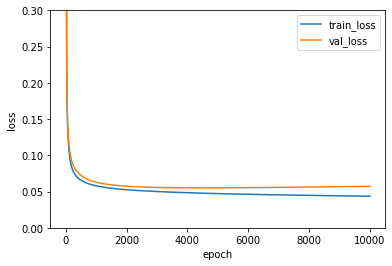

In [5]:
#검증 세트로 성능 측정

#score() 메서드로 출력하면 검증 세트의 점수는 05장과 동일하지만 손실 함수 값의 변화는 다르다.

plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

#손실값이 안정적으로 감소한다.

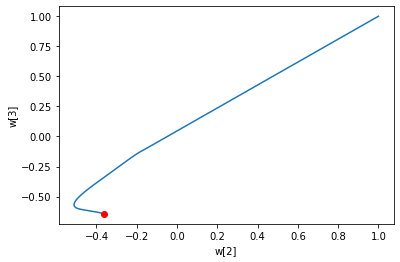

In [6]:
#가중치의 변화를 그래프로 나타내자

w2 = []
w3 = []
for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

#가중치를 찾는 경로가 다소 부드러운 곡선이다.
#가중치의 변화가 연속적이므로 손실값도 안정적으로 수렴한다.
#배치 경사 하강법의 단점 : 연산 비용이 많이 들고, 최솟값이 수렴하는 시간이 오래 걸린다.

***06-2 2개의 층을 가진 신경망 구현***

In [7]:
#SingleLayer 클래스 상속해 DualLayer 클래스 만들고 필요한 메서드 재정의

class DualLayer(SingleLayer):

  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
    self.units = units    #은닉층의 뉴런 개수
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []      #훈련 손실
    self.val_losses = []  #검증 손실
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1       #첫 번째 층의 선형식 계산
    self.a1 = self.activation(z1)           #활성화 함수 적용(SingleLayer클래스로부터 상속)
    z2 = np.dot(self.a1, self.w2) + self.b2 #두 번째 층의 선형식 계산
    return z2

  def backprop(self, x, err):
    m = len(x)      #샘플 개수
    #출력층의 가중치, 절편에 대한 gradient 계산
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    #sigmoid 함수까지 gradient 계산
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1)
    #은닉층의 가중치, 절편에 대한 gradient 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  #SingleLayer에서는 fit() 메서드를 한 덩어리로 작성했지만, DualLayer 클래스의 fit() 메서드는 3개의 작은 메서드로 쪼갠다.
  #1. 은닉층과 출력층의 가중치, 절편을 초기화
  #2. 에포크마다 정방향 계산 수행해 오차 계산
  #3. 오차 역전파해 가중치와 절편의 그레디언트 계산 및 업데이트
  #4. 손실 계산하여 누적

  def init_weights(self, n_features): #1
    self.w1 = np.ones((n_features, self.units)) #(특성 개수, 은닉층의 크기)
    self.b1 = np.zeros(self.units)              #은닉층의 크기
    self.w2 = np.ones((self.units, 1))          #(은닉층의 크기, 1(=출력층의 크기))
    self.b2 = 0

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): #4
    y = y.reshape(-1, 1)               #타깃을 열벡터로 바꾼다.
    y_val = y_val.reshape(-1, 1)
    m = len(y)                        #샘플 개수
    self.init_weights(x.shape[1])     #은닉층, 출력층의 가중치 초기화
    for i in range(epochs):
      a = self.training(x, y, m)      #fit() 메서드의 for문 안에 있는 코드 중 일부를 training 메서드로 분리
      a = np.clip(a, 1e-10, 1-1e-10)  #안전한 로그 계산 위해 클리핑
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a))) #로그 손실
      self.losses.append((loss + self.reg_loss()) / m)  #로그 손실과 규제 손실 더해 리스트에 추가
      self.update_val_loss(x_val, y_val)                #검증 세트에 대한 손실 계산

  def training(self, x, y, m): #2,3
    z = self.forpass(x)       #정방향 계산 수행
    a = self.activation(z)    #활성화 함수 적용
    err = -(y - a)            #오차 계산
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)      #오차 역전파 해 그레디언트 계산
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m #그레디언트에서 패널티 항 미분값 뺀다
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad  #은닉층 업데이트
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad  #출력층 업데이트
    return a  #출력층의 활성화 출력 a 반환

  def reg_loss(self): #은닉층과 출력층의 가중치에 규제 적용
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [8]:
#모델 훈련

dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

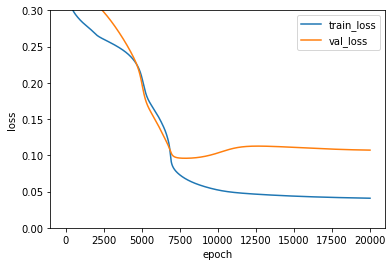

In [9]:
#훈련 손실 그래프 : 훈련 데이터로 손실 함수의 최솟값 찾아가는 과정
#검증 손실 그래프 : 검증 데이터로 손실 함수의 최솟값 찾아가는 과정

plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

#가중치의 개수가 훨씬 많아져 학습하는 데 시간이 오래걸려 손실 그래프가 SingleLayer클래스보다 천천히 감소한다.
#SingleLayer : 위스콘신 유방암 데이터의 특성이 30개이므로 가중치 30개와 절편 1개 = 31개의 변수 학습
#DualLayer : 은닉층 뉴런이 10개이므로 은닉층에 30*10개의 가중치와 10개의 절편, 출력층에 10개의 가중치와 1개의 절편 = 321개의 변수 학습

In [10]:
#가중치 초기화 개선
#초기 손실값이 감소하는 곡선이 매끄럽지 않다. (=손실 함수가 감소하는 방향을 올바르게 찾는 데 시간이 많이 소요되었다)
#가중치를 1로 초기화하지 않고 정규 분포 따르는 무작위 수로 초기화한다.

#DualLayer 클래스 상속한 클래스 만들어 init_weights() 메서드 수정
class RandomInitNetwork(DualLayer):

  def init_weights(self, n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_features, self.units)) #평균, 분산, (특성 개수, 은닉층의 크기)
    self.b1 = np.zeros(self.units)                             #은닉층의 크기
    self.w2 = np.random.normal(0, 1, (self.units, 1))          #평균, 분산, (은닉층의 크기, 1)
    self.b2 = 0

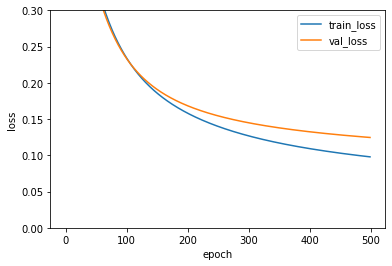

In [11]:
#훈련 및 손실함수 그리기

random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

plt.ylim(0, 0.3)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

#손실함수가 감소하는 곡선이 매끄럽고 손실 함수 값이 빠르게 감소한다.

***06-3 미니 배치 사용해 모델 훈련***

In [12]:
class MinibatchNetwork(RandomInitNetwork):

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    super().__init__(units, learning_rate, l1, l2)
    self.batch_size = batch_size  #배치 크기

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): #epoch 순회하는 for문 안에 미니 배치 순회하는 for문이 추가된다.
    y_val = y_val.reshape(-1, 1)
    self.init_weights(x.shape[1]) #은닉층과 출력층의 가중치 초기화
    np.random.seed(42)
    for i in range(epochs):
      loss = 0    #손실 초기화
      for x_batch, y_batch in self.gen_batch(x, y): #미니배치 순회
        y_batch = y_batch.reshape(-1, 1)    #타겟을 열 벡터로 바꾼다.
        m = len(x_batch)
        a = self.training(x_batch, y_batch, m)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a))) #매 미니배치마다 손실 누적
      self.losses.append((loss + self.reg_loss()) / len(x))            #로그 손실과 규제 손실 더해 리스트에 추가
      self.update_val_loss(x_val, y_val)

  def gen_batch(self, x, y): #미니 배치 만들어 반환
    length = len(x)
    bins = length // self.batch_size  #미니 배치 횟수
    if length % self.batch_size:
      bins += 1                       #나누어 떨어지지 않을 때
    indexes = np.random.permutation(np.arange(len(x)))  #인덱스를 섞는다
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]  #batch_size만큼 슬라이싱하여 반환

0.978021978021978


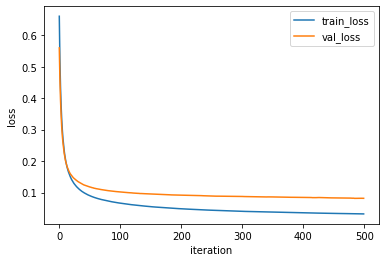

In [13]:
#미니 배치 경사 하강법 적용(batch_size=32)

minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
print(minibatch_net.score(x_val_scaled, y_val))

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

#배치 경사 하강법보다 수렴 속도가 빠르다.

0.978021978021978


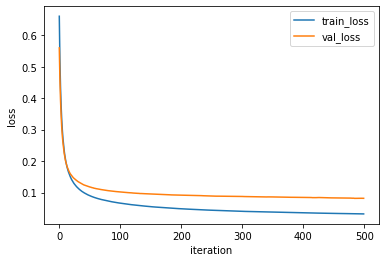

In [14]:
#미니 배치 경사 하강법 적용(batch_size=128)

minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
print(minibatch_net.score(x_val_scaled, y_val))

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

#batch_size=32 보다 손실 그래프는 조금 더 안정적으로 바뀌었지만, 손실값이 줄어드는 속도는 느려졌다.

사이킷런 사용해 다층 신경망 훈련하기

In [15]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic', solver='sgd', alpha=0.01, batch_size=32, learning_rate_init=0.1, max_iter=500)

#hidden_layer_sizes : 은닉층의 수와 뉴런의 개수 튜플로 전달. 기본값은 (100, )이다. 10개의 뉴런을 가진 2개의 은닉층 만들려면 (10, 10)과 같이 설정
#activation : 활성화함수 설정. 기본값은 'ReLU'. 여기서는 시그모이드함수 사용 위해 'logistic' 전달. 사이킷런의 신경말 모델은 은닉층마다 다른 활성화 함수 지정 불가능
#solver : 경사하강법 알고리즘 종류 지정. 기본값은 확률정 경사 하강법 의미하는 'sgd'
#alpha : 규제 적용 위한 매개변수. 사이킷런 신경망 모델은 L2 규제만 지원한다. alpha 매개변수는 규제의 양을 제어. 기본값은 0.0001.
#batch_size : 배치 크기 설정. 기본값 200


In [16]:
#모델 훈련
mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)

0.989010989010989